In [ ]:
!unzip data.zip

In [2]:
import numpy as np
import pandas as pd
import os
import cv2, pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 딥러닝 라이브러리
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- 1. 파라미터 설정 ---
# (원본 코드와 동일)
epochs = 15
batch_size = 32
img_height, img_width = 300, 300
input_shape = (img_height, img_width, 3)

# --- 2. 데이터 로드 및 EDA (분석 강화) ---

def create_data_sparse():
    # 이미지 정규화 (0~255 -> 0~1)
    data_gen = ImageDataGenerator(rescale=1.0 / 255)

    # ./data/Vegetable Images/train/ 디렉토리에서 학습 데이터 로드
    train_ds = data_gen.flow_from_directory(
        '/content/Vegetable Images/train/',
        target_size=(img_height, img_width),
        class_mode='sparse',
        batch_size=batch_size,
        subset='training'
    )

    # ./data/Vegetable Images/test/ 디렉토리에서 테스트 데이터 로드
    val_ds = data_gen.flow_from_directory(
        '/content/Vegetable Images/test',
        target_size=(img_height, img_width),
        class_mode='sparse',
        batch_size=batch_size,
        shuffle=False  # 평가지표 계산을 위해 shuffle=False 설정
    )

    return train_ds, val_ds

# 데이터셋 생성
train_ds, val_ds = create_data_sparse()

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [3]:
# 클래스 이름 추출 (15개 채소 이름)
class_names = list(train_ds.class_indices.keys())
print(f"총 {len(class_names)}개 클래스 발견: {class_names}")

총 15개 클래스 발견: ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']



--- EDA: 학습 데이터 샘플 이미지 확인 ---
샘플 이미지 그리드 'vegetable_samples.png' 저장 완료.



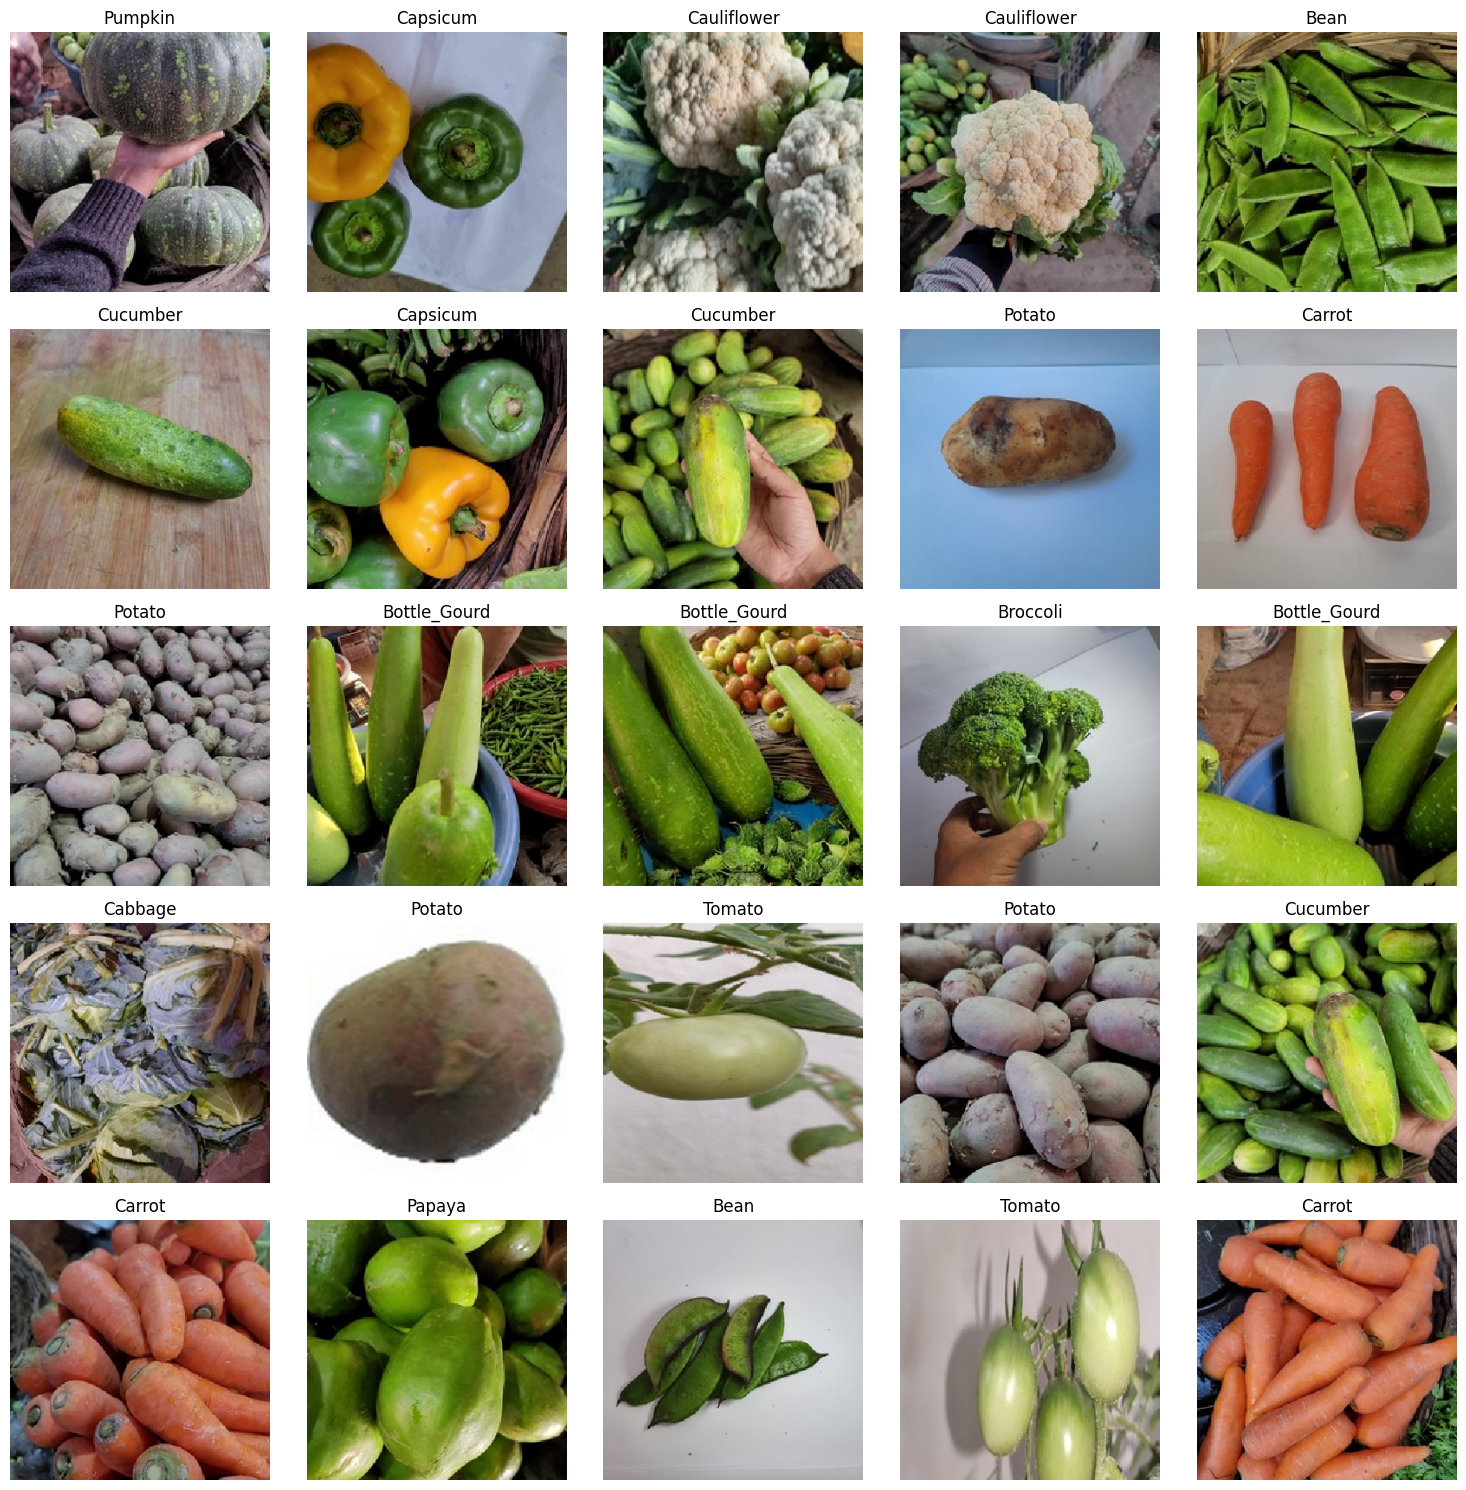

In [4]:
# [EDA 추가]: 학습 데이터 샘플 시각화
print("\n--- EDA: 학습 데이터 샘플 이미지 확인 ---")
images, labels = next(train_ds)  # 첫 번째 배치(32개) 가져오기

plt.figure(figsize=(15, 15))
for i in range(min(25, len(images))):  # 최대 25개 이미지 표시 (5x5 그리드)
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    # 라벨이 정수(sparse)이므로 class_names 리스트에서 해당 이름 조회
    plt.title(class_names[int(labels[i])])
    plt.axis('off')
plt.tight_layout()
plt.savefig('vegetable_samples.png')
print("샘플 이미지 그리드 'vegetable_samples.png' 저장 완료.\n")

In [5]:
# --- 3. CNN 모델 구축 (Keras Subclassing) ---

class BaseCNNNetwork(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides, padding, dropout_rate):
        super(BaseCNNNetwork, self).__init__()
        self.C1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPooling2D(2, padding=padding)
        self.Dr1 = Dropout(dropout_rate)

    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)
        y = self.Dr1(x)
        return y

In [6]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.C1 = Conv2D(32, (3 * 3), padding='same', input_shape=input_shape)
        self.B1 = BatchNormalization()
        self.A1 = Activation('relu')
        self.P1 = MaxPooling2D(2, padding='same')

        self.Layer1 = BaseCNNNetwork(filters=32, kernel_size=(3 * 3), strides=1, padding='same', dropout_rate=0.3)
        self.Layer2 = BaseCNNNetwork(filters=64, kernel_size=(3 * 3), strides=1, padding='valid', dropout_rate=0.4)
        self.Layer3 = BaseCNNNetwork(filters=32, kernel_size=(3 * 3), strides=1, padding='same', dropout_rate=0.3)

        self.F1 = Flatten()
        self.D1 = Dense(128, activation='relu')
        self.B2 = BatchNormalization()
        self.D2 = Dense(128, activation='relu')
        self.D3 = Dense(15, activation='softmax')  # 15개 클래스

    def call(self, x):
        x = self.C1(x)
        x = self.B1(x)
        x = self.A1(x)
        x = self.P1(x)

        x = self.Layer1(x)
        x = self.Layer2(x)
        x = self.Layer3(x)

        x = self.F1(x)
        x = self.D1(x)
        x = self.B2(x)
        x = self.D2(x)
        y = self.D3(x)
        return y

In [13]:
# --- 4. 모델 컴파일 및 훈련 ---

net = MyModel()

net.compile(optimizer='adam',
           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
           metrics=['sparse_categorical_accuracy'])

print("\n--- 모델 훈련 시작 ---")
history = net.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
)



--- 모델 훈련 시작 ---
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 213ms/step - loss: 2.2471 - sparse_categorical_accuracy: 0.2257 - val_loss: 1.3612 - val_sparse_categorical_accuracy: 0.5420
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 165ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.5886 - val_loss: 0.9945 - val_sparse_categorical_accuracy: 0.6740
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - loss: 0.8906 - sparse_categorical_accuracy: 0.7094 - val_loss: 0.8771 - val_sparse_categorical_accuracy: 0.7227
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 168ms/step - loss: 0.6994 - sparse_categorical_accuracy: 0.7741 - val_loss: 0.7786 - val_sparse_categorical_accuracy: 0.7693
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 77s 164ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.8348 - val_loss: 0.7466 - val_sparse_categorical_accuracy: 0.7833
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 168ms/step - loss: 0.3971 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.7024 - val_spa


훈련/검증 히스토리 그래프 'training_history.png' 저장 완료.


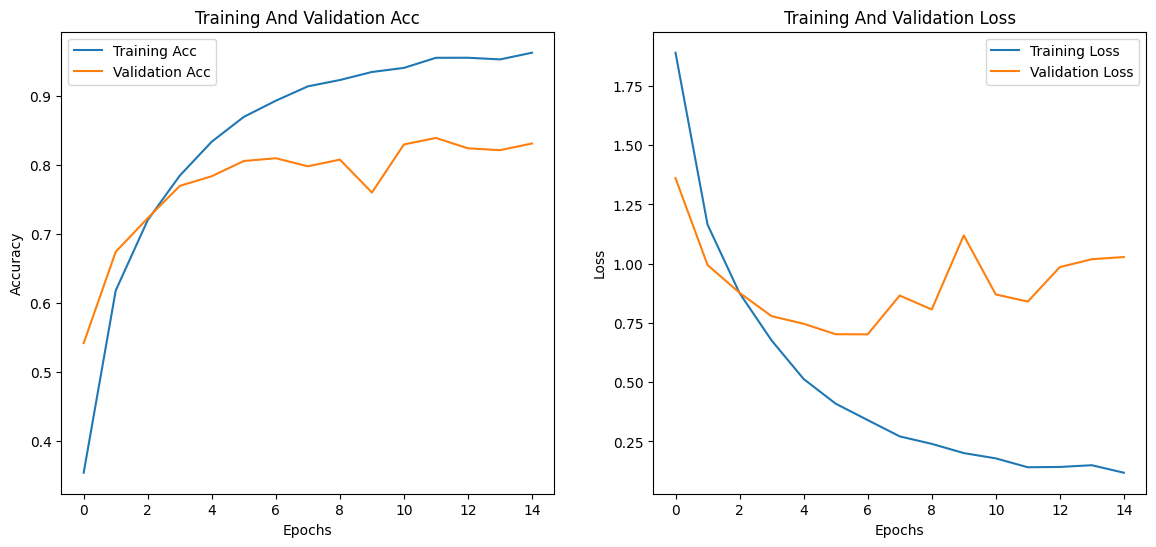

In [14]:
# --- 5. 상세 결과 분석 및 시각화 (분석 강화) ---

# 5-1. 훈련/검증 히스토리 시각화 (원본 코드 유지)
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 6)) # 그래프 크기 조절

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Training And Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training And Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.savefig('training_history.png')
print("\n훈련/검증 히스토리 그래프 'training_history.png' 저장 완료.")
plt.show()

In [15]:
# [결과 분석 추가 1]: 정량적 테스트 성능 평가
print("\n--- 최종 모델 성능 평가 (Test Data) ---")
results = net.evaluate(val_ds, batch_size=batch_size)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f} (약 {results[1]*100:.2f}%)")


--- 최종 모델 성능 평가 (Test Data) ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - loss: 1.1056 - sparse_categorical_accuracy: 0.8267
Test Loss: 1.0281
Test Accuracy: 0.8307 (약 83.07%)


In [16]:
# [결과 분석 추가 2]: 분류 리포트
# generator에서 실제 라벨(y_true)과 예측 라벨(y_pred) 추출
y_true = val_ds.classes
y_pred_probs = net.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step


In [17]:
# 테스트 데이터의 클래스 이름들 (train_ds와 순서 동일)
target_names = list(val_ds.class_indices.keys())

print("\n--- 상세 분류 리포트 (Test Data) ---")
print(classification_report(y_true, y_pred, target_names=target_names))


--- 상세 분류 리포트 (Test Data) ---
              precision    recall  f1-score   support

        Bean       0.80      0.78      0.79       200
Bitter_Gourd       0.86      0.81      0.83       200
Bottle_Gourd       0.90      0.94      0.92       200
     Brinjal       0.76      0.80      0.78       200
    Broccoli       0.83      0.75      0.79       200
     Cabbage       0.69      0.85      0.76       200
    Capsicum       0.84      0.86      0.85       200
      Carrot       0.98      0.80      0.88       200
 Cauliflower       0.84      0.77      0.80       200
    Cucumber       0.88      0.86      0.87       200
      Papaya       0.85      0.89      0.87       200
      Potato       0.80      0.99      0.89       200
     Pumpkin       0.89      0.76      0.82       200
      Radish       0.93      0.91      0.92       200
      Tomato       0.69      0.69      0.69       200

    accuracy                           0.83      3000
   macro avg       0.84      0.83      0.83      

In [18]:
# [결과 분석 추가 3]: 혼동 행렬 (Confusion Matrix) 시각화
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

혼동 행렬 히트맵 'confusion_matrix.png' 저장 완료.


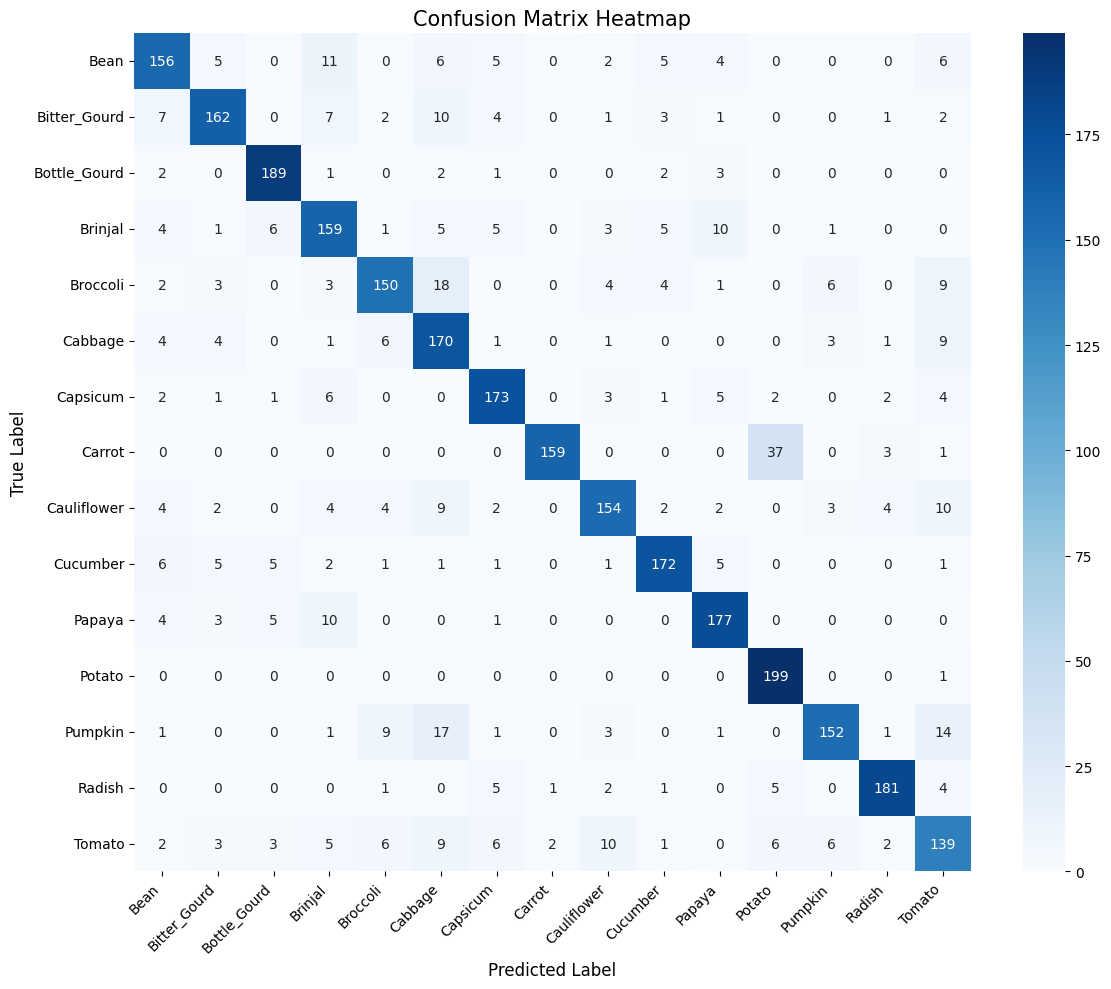

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap', fontsize=15)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("혼동 행렬 히트맵 'confusion_matrix.png' 저장 완료.")